In [22]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jre_utils.datapath import pretraining_data_paths

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [8]:
df = pd.read_csv(pretraining_data_paths["jena_climate"])
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')


In [9]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


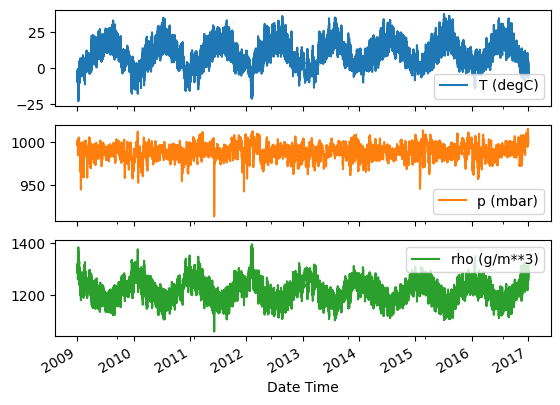

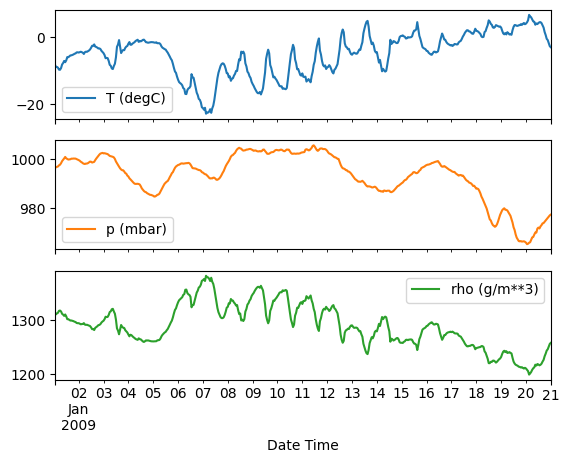

In [10]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [12]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

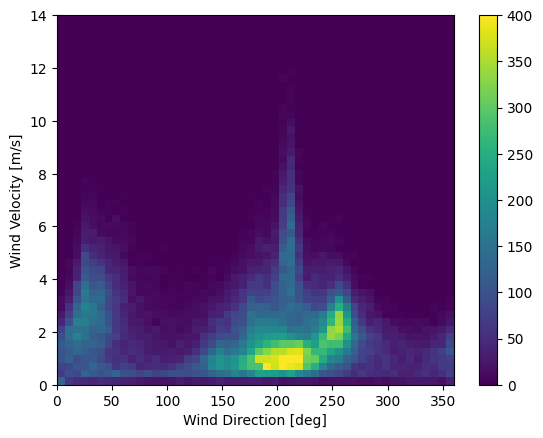

In [13]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')


In [14]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

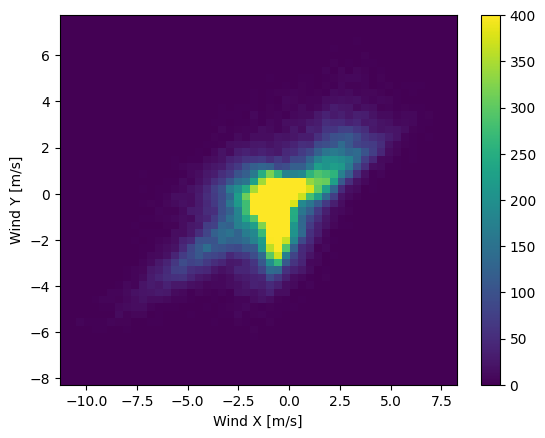

In [15]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')


In [16]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [17]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

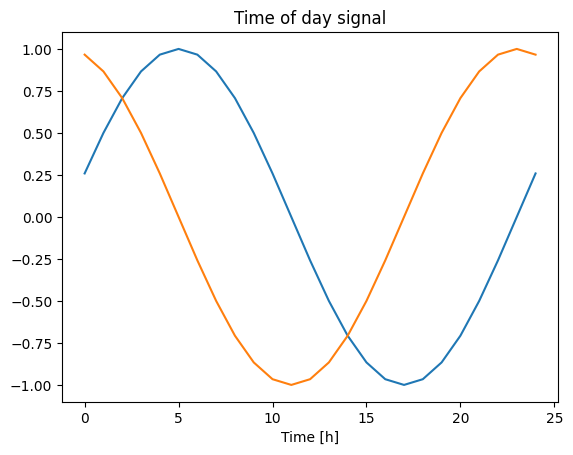

In [18]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [20]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [21]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

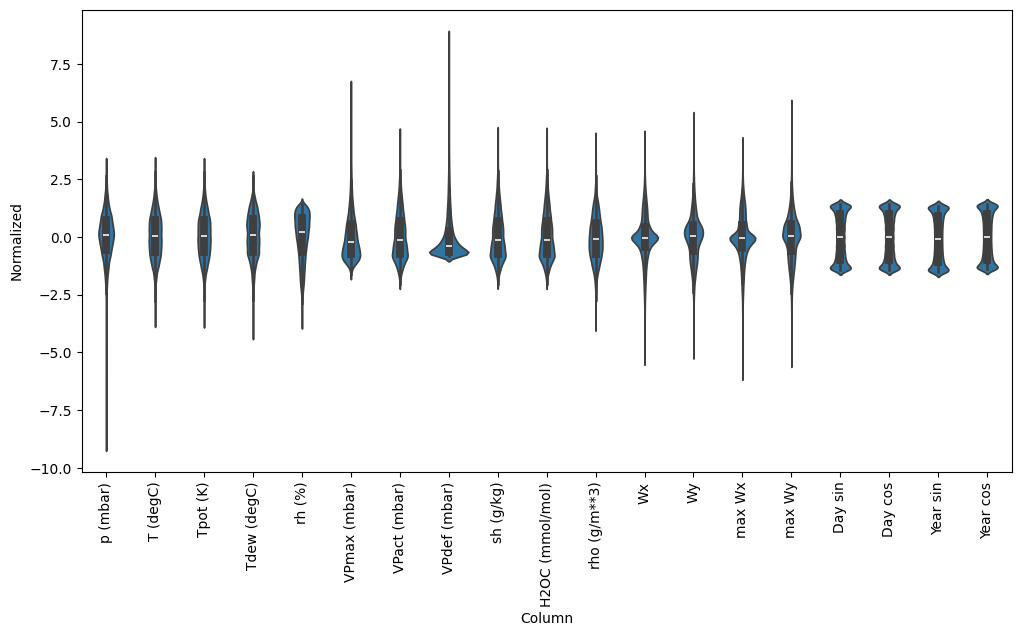

In [23]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [123]:
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        df,
        metrics=["target"],
        feature_columns=None,
        shift=1,
        window_length=6,
        transform=None,
    ):
        self.feature_columns = (
            feature_columns if feature_columns is not None else df.columns
        )
        self.df = df
        self.transform = transform
        self.metrics = metrics
        self.shift = shift
        self.window_length = window_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.df.iloc[idx]
        target = row[self.metrics]

        window_end = idx - self.shift + 1
        window_start = max(window_end - self.window_length, 0)
        window_end = max(window_end, 0)
        window = self.df.iloc[window_start : window_end]

        sample = {
            "window": window[self.feature_columns],
            "target": target,
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


class ToNumpy(object):
    """Convert pandas dataframes in sample to ndarrays."""

    def __call__(self, sample):
        window, target = sample["window"], sample["target"]
        return {"window": window.values, "target": target.values}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        window, target, mask = sample["window"], sample["target"], sample["mask"]
        return {
            "window": torch.from_numpy(window),
            "mask": torch.from_numpy(mask),
            "target": torch.from_numpy(target),
        }


class PadAndMask(object):
    """Pad all inputs to be of the same length and create a mask"""

    def __init__(self, pad_length=5):
        self.pad_length = pad_length

    def __call__(self, sample):
        window, target = sample["window"], sample["target"]

        # the first n elements of the mask are 1, the rest are 0
        mask = np.zeros(self.pad_length)
        mask[: window.shape[0]] = 1

        padded_window = np.pad(
            window, ((0, self.pad_length - window.shape[0]), (0, 0)), "constant"
        )
        return {"window": padded_window, "mask": mask, "target": target}

In [124]:
window_length = 3
shift = 1

train_dataset = TimeSeriesDataset(
    train_df,
    metrics=["T (degC)"],
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)
val_dataset = TimeSeriesDataset(
    val_df,
    metrics=["T (degC)"],
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)

In [125]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [126]:
for i, sample in enumerate(train_dataloader):
    if i == 0:
        print(i, sample["window"].shape, sample["target"].shape)
        break

0 torch.Size([32, 3, 19]) torch.Size([32, 1])


In [128]:
pd.DataFrame(sample["mask"][2])

,0
0,1.0
1,1.0
2,0.0


In [129]:
import math

from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer


In [130]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TimeSeriesTransformerModel(nn.Module):
    def __init__(
            self,
            n_features: int,
            d_model: int,
            nhead: int, 
            d_hid: int, 
            nlayers: int,
            dropout: float = 0.1,
            device: str = "cpu",
    ):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(n_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(self.encoder_layers, nlayers)
        self.linear = nn.Linear(d_model, 1)
        self.device = device

    def init_weights(self) -> None:
        initrange = 0.1
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, window: Tensor, mask: Tensor) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[batch_size, seq_len, n_features]`` -> ``[seq_len, batch_size, n_features]`` 
            src_mask: Tensor, shape ``[batch_size, seq_len]``
        
        Returns:
            output: Tensor, shape ``[batch_size, 1]``
        """
        window = window.permute(1, 0, 2)
        window = self.embedding(window)
        window = self.pos_encoder(window)
        output_layer = self.transformer_encoder(window, src_key_padding_mask=mask)
        pooled_output = torch.mean(output_layer, dim=0)
        final_output = self.linear(pooled_output)
        return final_output

In [131]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [140]:
n_features = len(df.columns)
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0.1

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)

In [141]:
data_iter = iter(train_dataloader)
batch = next(data_iter)
print(batch['window'].shape, batch['mask'].shape, batch['target'].shape)


torch.Size([32, 3, 19]) torch.Size([32, 3]) torch.Size([32, 1])


In [142]:
window = batch['window'].to(torch.float32).to(device)
mask = batch['mask'].to(torch.float32).to(device)
target = batch['target'].to(torch.float32).to(device)
model = model.to(device)

In [143]:
output = model(window, mask)
output.shape


torch.Size([32, 1])

In [144]:
learning_rate = 1e-3
num_epochs = 10

In [145]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

15340


In [146]:
from tqdm.auto import tqdm
from torch.nn import MSELoss
from torcheval.metrics import R2Score

mse_loss = MSELoss()

progress_bar = tqdm(range(num_training_steps))

train_losses, train_r2_scores, eval_losses, eval_r2_scores = [], [], [], []

phases = ["train", "eval"]

for epoch in range(num_epochs):
    running_loss = 0.0
    r2_score = R2Score(device=device)

    for phase in phases:
        if phase == "train":
            model.train()
            dataloader, losses, r2_scores = train_dataloader, train_losses, train_r2_scores
        else:
            model.eval()
            dataloader, losses, r2_scores = eval_dataloader, eval_losses, eval_r2_scores

        for batch in dataloader:
            window = batch["window"].to(torch.float32).to(device)
            mask = batch["mask"].to(torch.float32).to(device)
            target = batch["target"].to(torch.float32).to(device)

            outputs = model(window, mask)
            loss = mse_loss(outputs, target)

            if phase == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                progress_bar.update(1)

            running_loss += loss.item() * len(batch)
            r2_score.update(outputs, target)

        losses.append(running_loss / len(train_dataloader))
        r2_scores.append(r2_score.compute().item())

progress_bar.close()

100%|██████████| 15340/15340 [19:43<00:00, 12.96it/s]  


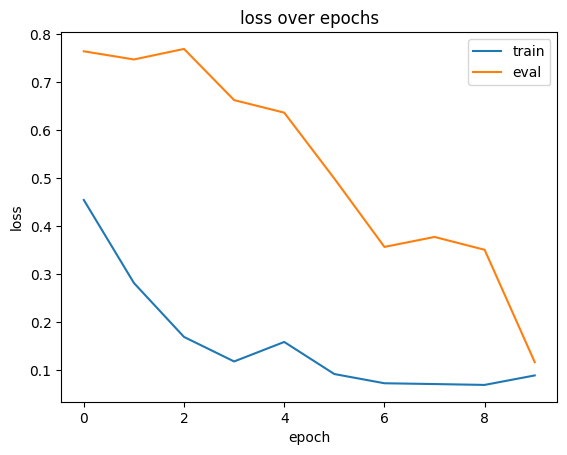

In [147]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

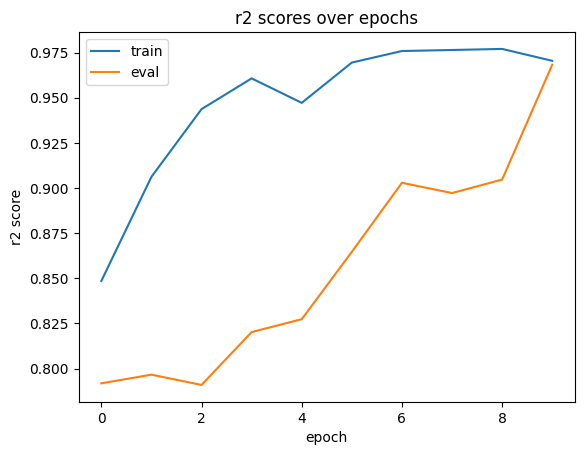

In [148]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [156]:
print(model.transformer_encoder)

TransformerEncoder(
  (layers): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=256, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)
